In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import (ConfusionMatrixDisplay, 
                            confusion_matrix, 
                            precision_score, 
                            recall_score, 
                            f1_score, 
                            accuracy_score, 
                            classification_report)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from data_transform import ColumnDropper, CategorizerFeatures, OrdinalEncoderTransformer, OneHotEmbarkedAndPclassEncoder

In [2]:
df = pd.read_csv('dataset/titanicc/train.csv')

In [3]:
y = df['Survived']

In [4]:
colunas = ["PassengerId","Pclass","Name","Sex","Age","SibSp","Parch","Ticket","Fare","Cabin","Embarked"]

In [5]:
X = df[colunas]

In [6]:
X_test_final = pd.read_csv("dataset/titanicc/test.csv")

In [7]:
y_test_final = pd.read_csv('dataset/titanicc/gender_submission.csv')

In [8]:
y_test_final = y_test_final['Survived'].to_numpy()

In [9]:
ppl_transform = Pipeline([
    ('drop_columns', ColumnDropper(columns_to_drop=['Cabin', 'Name', 'Ticket'])),
    ('CategorizerFeatures', CategorizerFeatures()),
    ('ordinal_encoder', OrdinalEncoderTransformer(columns=['Sex'])),
    ('encoder', OneHotEmbarkedAndPclassEncoder()),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler()), 
])

In [10]:
rf = RandomForestClassifier()

param_grid = {
    'n_estimators': [25,50,75,100],          # número de árvores
    'min_samples_split': [2, 5, 10],               # mínimo de amostras para dividir um nó
    'min_samples_leaf': [1, 2, 4],                 # mínimo de amostras em uma folha
}

In [11]:
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1  # usa todos os núcleos disponíveis
)

In [12]:
X_ppl_rf=ppl_transform.fit_transform(X)

In [13]:
grid_search.fit(X_ppl_rf, y)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [25, 50, 75, 100]},
             scoring='accuracy', verbose=2)

In [14]:
print("Melhores parâmetros:", grid_search.best_params_)
print("Melhor score:", grid_search.best_score_)
rfc_params = grid_search.best_params_

Melhores parâmetros: {'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 75}
Melhor score: 0.8182097796748478


In [15]:
model = make_pipeline(ppl_transform,RandomForestClassifier(bootstrap = True, max_depth= None,
                                                           max_features='sqrt', random_state = 42, **rfc_params) )

In [16]:
model.fit(X,y)

y_pred_rf = model.predict(X_test_final)

print(classification_report(y_test_final, y_pred_rf))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84       266
           1       0.72      0.75      0.73       152

    accuracy                           0.80       418
   macro avg       0.79      0.79      0.79       418
weighted avg       0.80      0.80      0.80       418



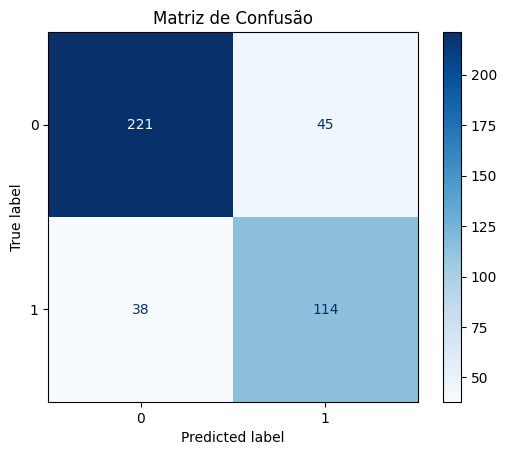

In [17]:
ConfusionMatrixDisplay.from_predictions(y_test_final, y_pred_rf, cmap='Blues')
plt.title("Matriz de Confusão")
plt.show()